In [1]:
!pip install tensorflow matplotlib


In [2]:
!pip install numpy

In [3]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 585.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
 

In [4]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


2.18.0


In [5]:
IMAGE_SIZE=222
BATCH_SIZE=22
CHANNELS=3
EPOCHS=50

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Coffee-disease",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1800 files belonging to 3 classes.


In [15]:
class_names=dataset.class_names
class_names

['Cercospora', 'Healty', 'Rust']

In [17]:
len(dataset)

82

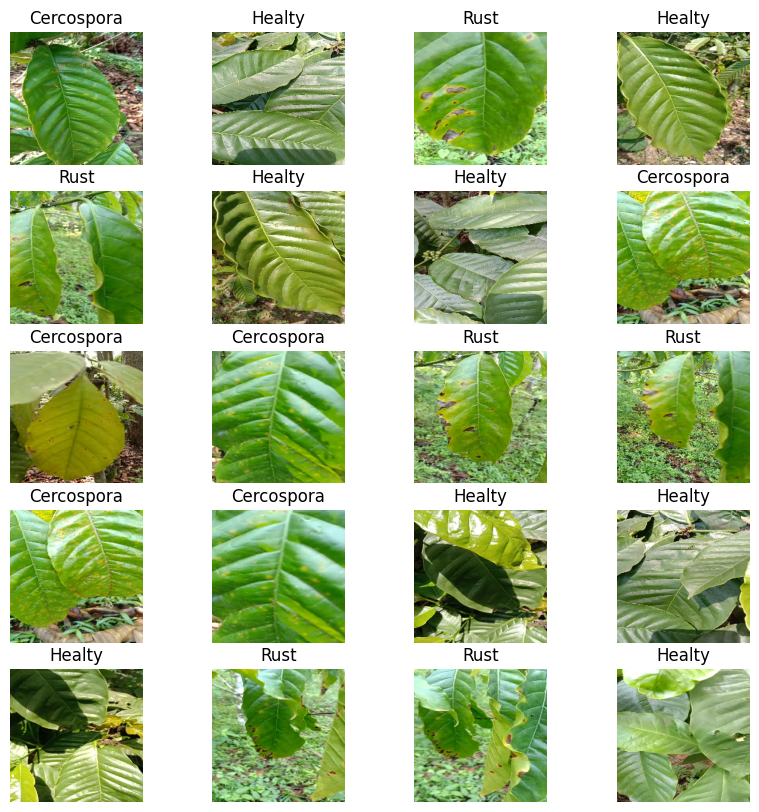

In [18]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax=plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [19]:
len(dataset)

82

In [20]:
train_size=0.8
int(len(dataset)*train_size)

65

In [21]:
train_ds=dataset.take(40)
len(train_ds)

40

In [22]:
test_ds=dataset.skip(40)
len(
    test_ds)

42

In [23]:
val_size=0.1
int(len(dataset)*val_size)

8

In [24]:
val_ds=test_ds.take(5)
len(val_ds)

5

In [25]:
test_ds=test_ds.skip(5)
len(test_ds)

37

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [27]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)


In [28]:
len(train_ds)


65

In [29]:
len(val_ds)


8

In [30]:
len(test_ds)


9

In [31]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [33]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),
    layers.RandomRotation(0.2)
])

In [34]:
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

# Define the input shape excluding the batch size
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Define the Sequential model with six Conv2D and corresponding MaxPooling2D layers
model = models.Sequential([
    # Input Layer
    layers.Input(shape=input_shape),

    # Data Preprocessing Layers
    resize_and_rescale,    # Resizes images to (IMAGE_SIZE, IMAGE_SIZE) and rescales pixel values
    data_augmentation,     # Applies data augmentation techniques

    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Convolutional Block 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Convolutional Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Convolutional Block 6
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

# Print the model summary to verify the architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 222, 222, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 222, 222, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 222, 222, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 111, 111, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 111, 111, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 111, 111, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 111, 111, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 55, 55, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 55, 55, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 55, 55, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 55, 55, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,170,659 (54.06 MB)

 Trainable params: 14,162,595 (54.03 MB)

 Non-trainable params: 8,064 (31.50 KB)

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7301 - loss: 1.0158 - val_accuracy: 0.3239 - val_loss: 6.0602
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9265 - loss: 0.2192 - val_accuracy: 0.3239 - val_loss: 8.0726
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9592 - loss: 0.0915 - val_accuracy: 0.3239 - val_loss: 28.7454
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9467 - loss: 0.1889 - val_accuracy: 0.3239 - val_loss: 12.7353
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9660 - loss: 0.0903 - val_accuracy: 0.3239 - val_loss: 11.8812
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9818 - loss: 0.0535 - val_accuracy: 0.3352 - val_loss: 9.8367
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9884 - loss: 0.0348 - val_accuracy: 0.6023 - val_loss: 4.1033
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9811 - loss: 0.0612 - val_accuracy: 0.7330 

In [37]:
scores=model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 1.0000 - loss: 0.0021


In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [39]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

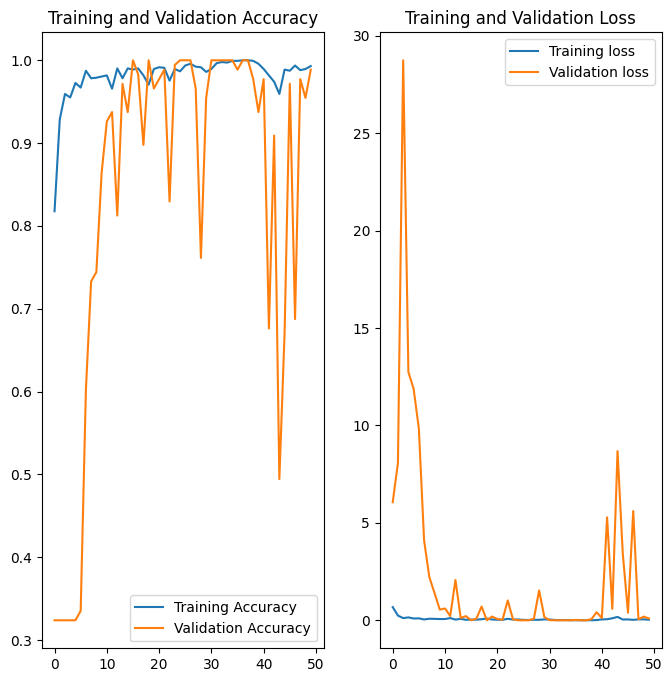

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right') # Changed 'upperr right' to 'upper right'
plt.title('Training and Validation Loss')

First image to predict
actual label:  Cercospora
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Predicted label: Cercospora


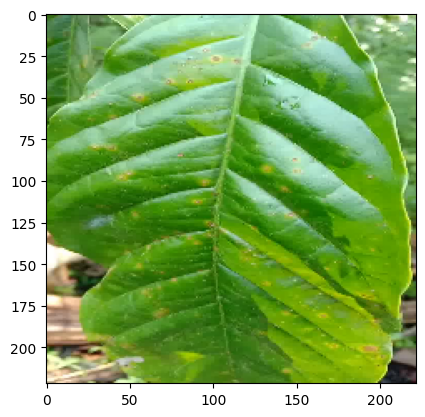

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("actual label: ",class_names[first_label])

    batch_prediction=model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array, 0) #create a batch

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


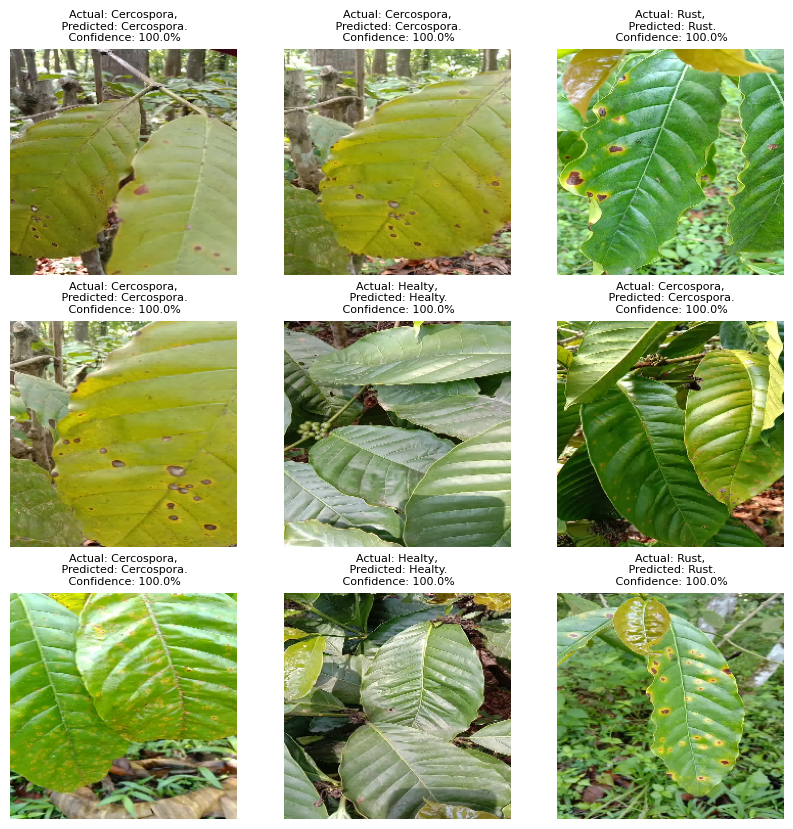

In [47]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence=predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%",fontsize=8)

        plt.axis("off")

In [59]:
from tensorflow.keras.models import load_model
import os

# Define the directory where you want to save the model
save_dir = '/content/drive/MyDrive/model'

# Check if the directory exists, and if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the model
model.save(os.path.join(save_dir, "model.keras"))